#dataset link
http://archive.ics.uci.edu/ml/machine-learning-databases/00235/*italicized 

In [ ]:
#imports

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
zip_path = tf.keras.utils.get_file( 
    origin='http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip',

    fname='household_power_consumption.zip',
    extract=True)

print(zip_path)

20640916/20640916 [==============================] - 1s 0us/step
/root/.keras/datasets/household_power_consumption.zip


In [ ]:
csv_path, _ = os.path.splitext(zip_path) 
print(csv_path)

/root/.keras/datasets/household_power_consumption


In [ ]:
! ls /root/.keras/datasets

household_power_consumption.txt  household_power_consumption.zip


In [ ]:
df = pd.read_csv('/root/.keras/datasets/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'],index_col='dt')

In [ ]:
df.columns[df.isnull().any()]

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [ ]:

df=df.interpolate(method ='linear', limit_direction ='forward')

In [ ]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [ ]:
df.head(5)
from google.colab import files
fig = plt.figure(figsize=(15, 15))
plt.savefig("Fid.png", bbox_inches='tight')
files.download("Fid.png")

In [ ]:
df.shape

(2075259, 7)

In [ ]:
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Observations:

One reading every 1 mins



Univariate LSTM



Univariate means we will only use Global_active_power to predict our values .

In [ ]:
# univariate data: Global_active_powe vs Time

uni_df = df['Global_active_power']

uni_df.head()


dt
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: Global_active_power, dtype: float64

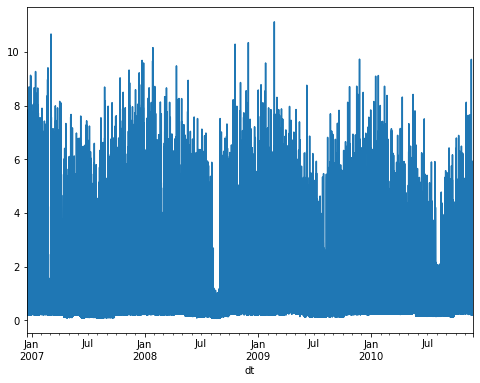

In [ ]:
uni_df.plot()
plt.savefig('file.png',dpi=300)

In [ ]:

uni_data = uni_df.values # numpy ndarray from pandas
TRAIN_SPLIT = 1800000 # First 180000 obs will be used as train data and rest as test data.




tf.random.set_seed(11) # random seed 

# Normalize data: mean centering and variance-scaling.
# NOTE: use only train data to normalize all of the data. otherwise, leakage-issue 
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
print(type(uni_data))

#test_unif_df  = pd.to_datetime(test['Date'])

<class 'numpy.ndarray'>


Creating data set for LSTM univariate using past 50 values

In [ ]:
train_split=1500000
test_split=1800000
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


# use the above function to create the datasets.
univariate_past_history = 100
univariate_future_target = 0 # we can change this if we want predicted value after some time

x_train_uni, y_train_uni = univariate_data(uni_data, 0,train_split,
                                           univariate_past_history,
                                            univariate_future_target)


x_var_uni, y_var_uni = univariate_data(uni_data,train_split,test_split,
                                           univariate_past_history,
                                          univariate_future_target)

x_test_uni, y_test_uni = univariate_data(uni_data,test_split, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)

print(x_var_uni.shape)
print(y_var_uni.shape)
print(x_test_uni.shape)
print(y_test_uni.shape)

(1499900, 100, 1)
(1499900,)
(299900, 100, 1)
(299900,)
(275159, 100, 1)
(275159,)


In [ ]:
print ('Single window of past history')
print (x_train_uni[2])
print ('\n Target value to predict')
print (y_train_uni[2])

In [ ]:
len(x_train_uni[0])

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

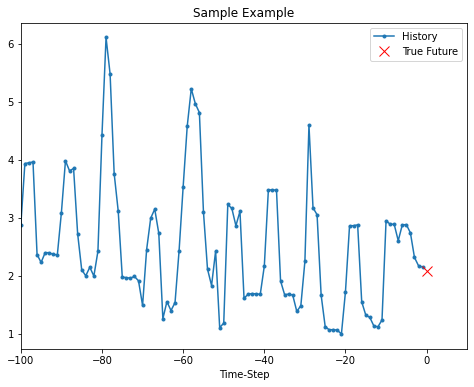

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

#creating tensor flow dataset

In [ ]:
# TF Dataset preperation
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_univariate = tf.data.Dataset.from_tensor_slices((x_var_uni, y_var_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

test_univariate = tf.data.Dataset.from_tensor_slices((x_test_uni, y_test_uni))
test_univariate = test_univariate.batch(BATCH_SIZE)



print(train_univariate)
print(val_univariate)
print(test_univariate)


<RepeatDataset element_spec=(TensorSpec(shape=(None, 100, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 100, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [ ]:
x_train_uni.shape

(1499900, 100, 1)

In [ ]:
univariate_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

univariate_lstm_model.compile(optimizer='adam', loss='mae')

print(univariate_lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
univariate_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
STEPS_PER_EPOCH = 200
EPOCHS = 10

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
univaruate_lstm_model_history=univariate_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 17s 70ms/step - loss: 0.5993 - val_loss: 0.2612
Epoch 2/10
200/200 [==============================] - 9s 43ms/step - loss: 0.2673 - val_loss: 0.1981
Epoch 3/10
200/200 [==============================] - 9s 43ms/step - loss: 0.1723 - val_loss: 0.1617
Epoch 4/10
200/200 [==============================] - 9s 43ms/step - loss: 0.1020 - val_loss: 0.1409
Epoch 5/10
200/200 [==============================] - 9s 43ms/step - loss: 0.1172 - val_loss: 0.1278
Epoch 6/10
200/200 [==============================] - 9s 44ms/step - loss: 0.0879 - val_loss: 0.1200
Epoch 7/10
200/200 [==============================] - 10s 47ms/step - loss: 0.0695 - val_loss: 0.1153
Epoch 8/10
200/200 [==============================] - 9s 44ms/step - loss: 0.0891 - val_loss: 0.1099
Epoch 9/10
200/200 [==============================] - 9s 43ms/step - loss: 0.0884 - val_loss: 0.1062
Epoch 10/10
200/200 [==============================] - 9s 43ms/step - loss: 0.1042 - val_

8/8 [==============================] - 0s 8ms/step


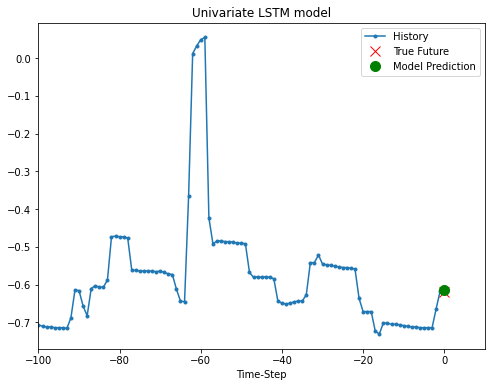

8/8 [==============================] - 0s 7ms/step


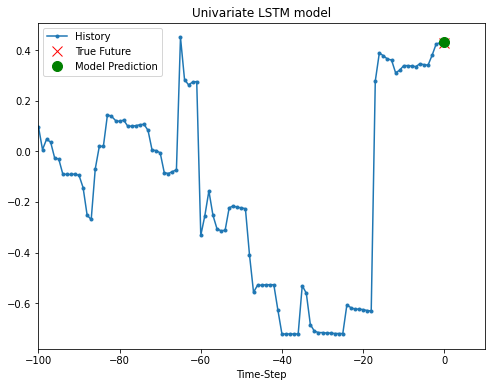

8/8 [==============================] - 0s 8ms/step


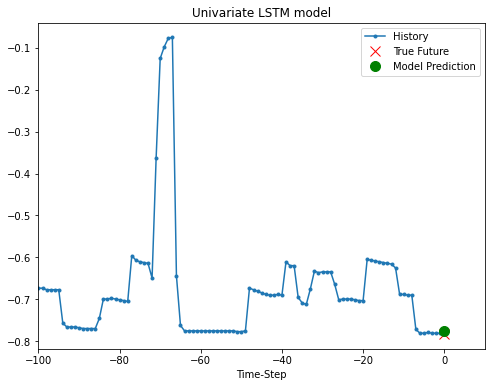

8/8 [==============================] - 0s 8ms/step


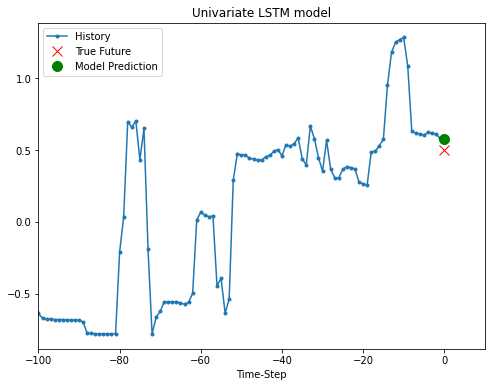

8/8 [==============================] - 0s 7ms/step


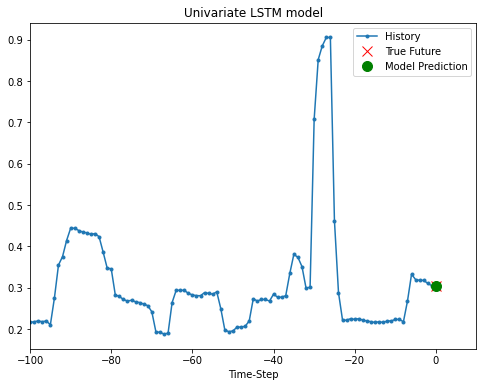

In [ ]:

for x, y in test_univariate.take(5): # take 5 random inputs from validation data
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    univariate_lstm_model.predict(x)[0]], 0, 'Univariate LSTM model')
  plot.show()

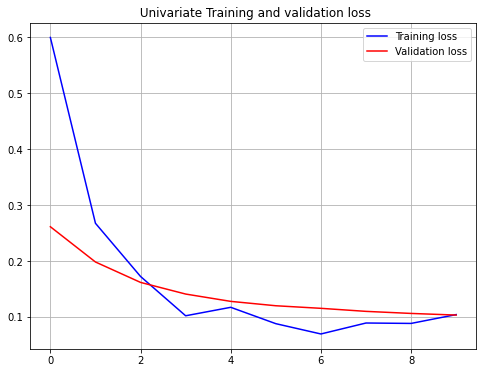

<Figure size 576x432 with 0 Axes>

In [ ]:

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



plot_train_history(univaruate_lstm_model_history,
                   ' Univariate Training and validation loss')
plt.savefig('file2.png',dpi=300)

In [ ]:
print("Evaluate")
result = univariate_lstm_model.evaluate(test_univariate)
print(result)

Evaluate
1075/1075 [==============================] - 19s 18ms/step - loss: 0.0670
0.06700926274061203
